# IMPORTS AND GENERAL FUNCTIONS

In [1]:
# default_exp preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import glob
import os
import chart_studio.plotly as py
import plotly.graph_objects as go
import missingno as msno
import itertools 
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble  import RandomForestRegressor

from modules import preprocessing as prep
from modules import data_management as dm
%load_ext autoreload
%autoreload 2

In [2]:
path_base = "./local/data/"

# METEREOLOGICAL DATA

In [3]:
df_dengue_city_week = pd.read_csv(path_base+"prepared_dengue/dengue_weekly_2007_2020.csv", index_col = 0, dtype = {"COD_DPTO":str,"SEMANA":str, "COD_MUNICIPIO":str})
df_dengue_city_week.head(3)

ANO SEMANA COD_MUNICIPIO COD_DPTO  DENGUE  DENGUE GRAVE  \
FECHA                                                                  
2006-12-31  2007     01         91000       91       0             0   
2007-01-07  2007     02         91000       91       0             0   
2007-01-14  2007     03         91000       91       0             0   

            MORTALIDAD POR DENGUE  
FECHA                              
2006-12-31                      0  
2007-01-07                      0  
2007-01-14                      0

# Workflow con datos del mapa del IDEAM

Poner en una única carpeta todos los archivos descargados para una ubicación dada.

Estoy trabajando en lograr que las descargas de la API queden con los mismos campos que las del IDEAM.

Las variables son: 

- "HRA2_AUT_60" <- HUMEDAD RELATIVA A 2 METROS, HORARIA
- "TA2_AUT_60" <- TEMPERATURA A 2 METROS, HORARIA
- "PTPM_CON" <- PRECIPITACIÓN, DIARIA
- "VV_AUT_2" <- VELOCIDAD DLE VIENTO CADA DOS MINUTOS

En todos los casos habrá que combinar datos de varias estaciones, los criterios preferibles son:

1. Correlación (implementación pendiente)
2. Proximidad en altitud (dato solo disponible para las estaciones del mapa del IDEAM)
3. Proximidad en longitud y latitud.

In [4]:
df_cities = dm.read_cities_file()
df_cities

department   municipality   code                  dl_folder  \
0            Antioquia       Medellín  05001              MEDELLIN_DATA   
1            Magdalena    Santa Marta  47001           SANTA_MARTA_DATA   
2            Santander    Bucaramanga  68001           BUCARAMANGA_DATA   
3            Atlántico   Barranquilla  08001  SOLEDAD_BARRANQUILLA_DATA   
4            Atlántico        Soledad  08758  SOLEDAD_BARRANQUILLA_DATA   
5   Norte de Santander         Cúcuta  54001                CUCUTA_DATA   
6      Valle del Cauca           Cali  76001                  CALI_DATA   
7              Caquetá  Villavicencio  50001         VILLAVICENCIO_DATA   
8               Tolima         Ibagué  73001                IBAGUE_DATA   
9              Córdoba       Montería  23001              MONTERIA_DATA   
10           Antioquia          Bello  05088              MEDELLIN_DATA   

   starting_date                   stations_temp  \
0     2011/05/20  [27015330, 27015310, 27015300]   
1     2008/06/28                      [15015120]   
2     2014/12/11                      [23195230]   
3     2013/05/03            [29045190, 29004520]   
4     2007/01/01                              []   
5     2006-09-03            [16015110, 16015501]   
6     2006/11/24            [26085170, 26055120]   
7     2007/03/18            [35035100, 35025110]   
8     2007/01/01                              []   
9     2007/01/01                              []   
10    2007/01/01                              []   

                      stations_hum                             stations_prec  \
0   [27015330, 27015310, 27015300]            [27015330, 27015290, 27011270]   
1                       [15015120]            [15015050, 15010501, 15015120]   
2                       [23195230]                                [23195230]   
3                       [29045190]            [29045120, 29040450, 29045190]   
4                               []                                        []   
5             [16015110, 16015501]            [16015110, 16015010, 16015501]   
6             [26085170, 26055120]            [26055120, 26080310, 26085170]   
7             [35035100, 35025110]  [35030380, 35030370, 35030100, 35035020]   
8                               []                                        []   
9                               []                                        []   
10                              []                                        []   

   stations_rad    range_temp    range_hum  
0            []  [15.5, 37.5]  [15, 99.99]  
1            []    [17.5, 40]  [40, 99.99]  
2            []      [17, 40]  [30, 99.99]  
3            []      [22, 45]  [45, 99.99]  
4            []            []           []  
5            []    [17.5, 45]  [30, 99.99]  
6            []    [16.5, 45]  [30, 99.99]  
7            []      [20, 45]  [35, 99.99]  
8            []            []           []  
9            []      [22, 45]  [45, 99.99]  
10           []      [22, 45]  [45, 99.99]

In [5]:
row_id = 5
params = {}
params_to_get = ["department","municipality","dl_folder","code", "starting_date","stations_temp","stations_hum","stations_prec","stations_rad","range_temp","range_hum"]
params = {param:df_cities.loc[row_id,param] for param in params_to_get}
params

{'department': 'Norte de Santander',
 'municipality': 'Cúcuta',
 'dl_folder': 'CUCUTA_DATA',
 'code': '54001',
 'starting_date': '2006-09-03',
 'stations_temp': [16015110, 16015501],
 'stations_hum': [16015110, 16015501],
 'stations_prec': [16015110, 16015010, 16015501],
 'stations_rad': [],
 'range_temp': [17.5, 45],
 'range_hum': [30, 99.99]}

In [6]:
municipality_name = params["municipality"]
cod_municipio = params["code"]
foldername = path_base+"src_per_city/"+params["dl_folder"]
filenames = sorted(glob.glob(foldername+'/*.csv'))
df = prep.read_csv_IDEAM(filenames).drop_duplicates()
df.drop_duplicates(subset=["CodigoEstacion"])

CodigoEstacion                                     NombreEstacion  \
0             16015110  UNIVERSIDAD FRANCISO DE PAULA SANTANDER - AUT ...   
68988         16015501            AEROPUERTO CAMILO DAZA - AUT [16015501]   
103440        16025040                       CINERA-VILLA OLGA [16025040]   
186471        16015010                  AEROPUERTO CAMILO DAZA [16015010]   
188296        16020320                              AGUABLANCA [16020320]   
188383        16020130                               BARRANCAS [16020130]   
190209        16020140                      BOCATOMA RIO ZULIA [16020140]   
192035        16025010                      CARMEN DE TONCHALA [16025010]   
193859        16020180                             CERRO PELAO [16020180]   
197413        16010060                                JARRA LA [16010060]   
199238        16010340                                TASAJERO [16010340]   
200939        16020250                               VACAS LAS [16020250]   
213808        16020340                                PLANADAS [16020340]   
222284        16010040                              SANTA RITA [16010040]   
710627        16017010                                AGUAS CLARAS  - AUT   
713181        16027280                                   ASTILLEROS - AUT   

             Latitud   Longitud  Altitud            Categoria  \
0       7.8987777780 -72.487167    311.0  Climática Principal   
68988   7.9316111110 -72.511250    313.0  Sinóptica Principal   
103440  8.1677777780 -72.468611    100.0  Climática Principal   
186471  7.9302777780 -72.509167    250.0  Sinóptica Principal   
188296  8.0361111110 -72.483611    250.0        Pluviométrica   
188383        8.2455 -72.526306     74.0        Pluviométrica   
190209  8.0773333330 -72.583889    150.0        Pluviométrica   
192035  7.8488888890 -72.566111    285.0  Climática Principal   
193859  8.0119444440 -72.500278    300.0        Pluviométrica   
197413  8.2019444440 -72.432222     87.0        Pluviométrica   
199238  7.9930277780 -72.461722    953.0        Pluviométrica   
200939  8.2191666670 -72.524556     70.0        Pluviométrica   
213808  8.2169444440 -72.436111    100.0        Pluviométrica   
222284  8.1855555560 -72.368333     72.0        Pluviométrica   
710627   8.233611111 -72.417222      NaN                   mm   
713181   8.105277778 -72.581389      NaN                   mm   

                                                  Entidad  \
0       INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
68988   INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
103440  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
186471  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
188296  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
188383  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
190209  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
192035  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
193859  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
197413  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
199238  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
200939  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
213808  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
222284  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
710627                                                NaN   
713181                                                NaN   

                                 AreaOperativa        Departamento Municipio  \
0       Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
68988   Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
103440  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
186471  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
188296  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
188383  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcu

# Workflow precipitación

1. Lectura y visualización inicial:

In [7]:
standard_var_name = "PRECIPITATION"
possible_prec_names = ["PTPM_CON","Precipitacion"]
df_prec = prep.get_variable_IDEAM(df, possible_prec_names, standard_var_name)
df_prec = prep.drop_duplicates_by_date_station(df_prec)
stations_prec = df.drop_duplicates(subset=["CodigoEstacion"])["CodigoEstacion"].values
df_prec = df_prec[df_prec["CodigoEstacion"].isin(stations_prec)]

In [8]:
fig = go.Figure()
for df_group in df_prec.groupby(["CodigoEstacion"]):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_lluvia = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name], name ="PP "+str(codigoestacion), mode = "lines")
    fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY " +standard_var_name + " IN " + municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [9]:
df_prec_daily = df_prec 
df_prec_daily.head()

CodigoEstacion  PRECIPITATION
DATE                                     
2010-01-01        16015010            0.0
2010-01-02        16015010            0.0
2010-01-03        16015010            0.0
2010-01-04        16015010            0.0
2010-01-05        16015010            0.0

### Escoger hasta 6 estaciones para el análisis de correlación, en caso de que hayan muchas estaciones, sino basta con utilizar el unique

In [10]:
stations_corr =  df_prec_daily["CodigoEstacion"].unique()
#stations_corr = [29004520, 29040450, 29045190]
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_prec_daily[df_prec_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['PRECIPITATION'],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['PRECIPITACION'] = corr_table.corr().iloc[0,1]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(prep.highlight_max, axis=1)
all_corr_df

16015010                                                   \
               16020320 16020130  16020140  16025010  16020180  16025040   
PRECIPITACION  0.228948  0.28988  0.418154  0.522209  0.485228  0.347135   

                                                    ...  16010040           \
              16010060 16010340  16020250 16020340  ...  16015110 16017010   
PRECIPITACION  0.30265  0.48684  0.241342  0.44355  ... -0.044075  0.34492   

                                   16015110                      16017010  \
               16015501  16027280  16017010  16015501  16027280  16015501   
PRECIPITACION  0.098111  0.054132  0.218168  0.448816  0.128929  0.242694   

                         16015501  
               16027280  16027280  
PRECIPITACION  0.263694  0.336238  

[1 rows x 120 columns]

##  2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.

In [11]:
if len(params["stations_prec"]) == 0:
    stations_priority = [35030380, 35030370,35030100, 35035020] 
    params["stations_prec"] = stations_priority
    df_cities.loc[row_id,"stations_prec"] = repr(stations_priority)
    df_cities.to_csv("params.csv", index = False)
else:
    stations_priority = params["stations_prec"]

df_prec_daily = prep.combine_IDEAM_stations(df_prec_daily, stations_priority).sort_index()
df_prec_daily = df_prec_daily.resample('D').mean()

In [12]:
fig = go.Figure()

plot_lluvia = go.Scatter(x=df_prec_daily.index, y=df_prec_daily[standard_var_name], name ="PP ", mode = "lines")
fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))

fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

3. Variables compuestas o derivadas de los valores diarios

# Workflow temperatura

In [13]:
standard_var_name = "TEMPERATURE"
possible_temp_names = ["TA2_AUT_60", "Temp Aire 2 m"]
df_temp = prep.get_variable_IDEAM(df, possible_temp_names, standard_var_name).sort_index()
df_temp = prep.drop_duplicates_by_date_station(df_temp)
stations_temp = df_temp.drop_duplicates(subset=["CodigoEstacion"])["CodigoEstacion"].values
df_temp = df_temp[df_temp["CodigoEstacion"].isin(stations_temp)]
stations_temp

array([16015110, 16015501, 16025040], dtype=int64)

1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

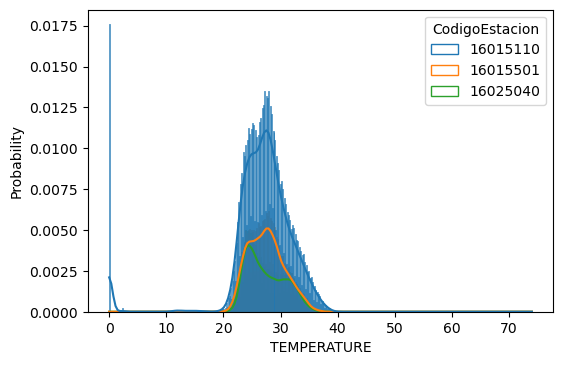

In [14]:
dfs = []
unique_stations = df_temp["CodigoEstacion"].unique()
fig = plt.figure(dpi=100)
sns.histplot(data = df_temp, x = "TEMPERATURE", hue = "CodigoEstacion",  palette = sns.color_palette("tab10")[0:len(unique_stations)], kde = True, fill = False, common_norm = True, stat = 'probability')
for i, codigoestacion in enumerate(unique_stations):
    df_temp_est =back = df_temp[df_temp["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    #print(codigoestacion,df_temp_est.describe())
    df_temp_est = prep.filter_entries_by_column_index_values(df_temp_est, standard_var_name, params["range_temp"][0],params["range_temp"][1]); # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_temp_est = prep.aggregate_data(df_temp_est, agg_type='daily', min_count = 12).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_temp_est.columns)
    df_temp_est["CodigoEstacion"] = codigoestacion
    df_temp_est = df_temp_est[columns]
    dfs.append(df_temp_est)
df_temp_daily = pd.concat(dfs, axis = 0)

In [15]:
fig = go.Figure()
for df_group in df_temp_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="TEMP "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='TEMP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [16]:
if params["municipality"] == "Medellín":
    indexes_fix = df_temp_daily["TEMPERATURE_MEAN"]>26.5
    df_temp_daily.loc[indexes_fix,["TEMPERATURE_MEAN","TEMPERATURE_AMAX","TEMPERATURE_AMIN"]] = None

In [17]:
stations_corr =  df_temp_daily["CodigoEstacion"].unique()
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_temp_daily[df_temp_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['TEMPERATURE_AMAX','TEMPERATURE_AMIN',"TEMPERATURE_MEAN"],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['TEMPERATURE_AMAX'] = corr_table.corr().iloc[0,1]
    dict_pair['TEMPERATURE_AMIN'] = corr_table.corr().iloc[2,3]
    dict_pair['TEMPERATURE_MEAN'] = corr_table.corr().iloc[4,5]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(prep.highlight_max, axis=1)
all_corr_df

16015110            16015501
                  16015501  16025040  16025040
TEMPERATURE_AMAX  0.952216  0.763697  0.799248
TEMPERATURE_AMIN  0.921035  0.588206  0.576603
TEMPERATURE_MEAN  0.965292  0.856742  0.872950

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [18]:
# Manually set the priorities for the temperature stations as per the above results!
#params["stations_temp"] = []
if len(params["stations_temp"]) == 0:
    stations_priority = [27015330,27015310, 27015300]
    params["stations_temp"] = stations_priority
    df_cities.loc[row_id,"stations_temp"] = repr(stations_priority)
    df_cities.to_csv("params.csv", index = False)
else:
    stations_priority = params["stations_temp"]

#stations_priority = [26085170,26055120] #Cali
#stations_priority = [29045190, 29004520   ] #Barranquilla
df_temp_daily = prep.combine_IDEAM_stations(df_temp_daily, stations_priority).sort_index()
df_temp_daily = df_temp_daily.resample('D').mean()

#df_temp_daily = df_temp_daily[df_temp_daily.index.date >= pd.to_datetime("2013/05/01")]

In [19]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_temp_daily.index,
            y=df_temp_daily[standard_var_name+"_MEAN"], name ="CC", mode = "lines", marker_color = "red")
fig.add_trace(plot_temp)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [20]:
#dfa = df_temp_daily.groupby(df_temp_daily.index.year).mean().reset_index()
#dfa

# Workflow humedad

In [21]:
standard_var_name = "REL_HUMIDITY"
possible_hum_names = ["HRA2_AUT_60","Humedad del aire 2 mt"]
df_hum = prep.get_variable_IDEAM(df, possible_hum_names, standard_var_name).sort_index()
df_hum = prep.drop_duplicates_by_date_station(df_hum)
stations_hum = df_hum.drop_duplicates(subset=["CodigoEstacion"])["CodigoEstacion"].values
df_hum = df_hum[df_hum["CodigoEstacion"].isin(stations_hum)]
df_hum.head(3)

CodigoEstacion  REL_HUMIDITY
DATE                                             
2005-09-09 18:00:00        16015110          58.0
2005-09-09 19:00:00        16015110          60.0
2005-09-09 20:00:00        16015110          62.0

1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

CodigoEstacion  REL_HUMIDITY_MEAN  REL_HUMIDITY_AMAX  REL_HUMIDITY_AMIN
count    8.364000e+03        8364.000000        8364.000000        8364.000000
mean     1.601678e+07          70.790428          86.478001          52.499044
std      3.592133e+03          10.895994          10.167890          11.837418
min      1.601511e+07          41.045455          50.000000          30.000000
25%      1.601511e+07          62.250000          81.750000          43.000000
50%      1.601511e+07          72.000000          88.000000          53.000000
75%      1.601550e+07          79.208333          94.000000          61.000000
max      1.602504e+07          99.000000          99.000000          99.000000

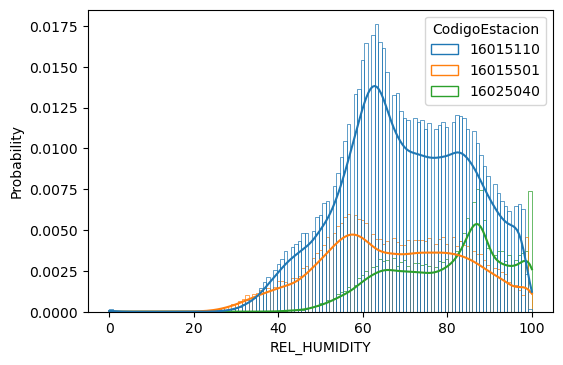

In [22]:
dfs = []
unique_stations = df_hum["CodigoEstacion"].unique()
fig = plt.figure(dpi=100)
sns.histplot(data = df_hum, x = "REL_HUMIDITY", hue = "CodigoEstacion",  palette = sns.color_palette("tab10")[0:len(unique_stations)], kde = True, fill = False, common_norm = True, stat = 'probability')
for codigoestacion in df_hum["CodigoEstacion"].unique():
    df_hum_est = df_hum[df_hum["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    df_hum_est = prep.filter_entries_by_column_index_values(df_hum_est, standard_var_name, params["range_hum"][0],params["range_hum"][1]) # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_hum_est = prep.aggregate_data(df_hum_est, agg_type='daily', min_count = 6).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_hum_est.columns)
    df_hum_est["CodigoEstacion"] = codigoestacion
    df_hum_est = df_hum_est[columns]
    dfs.append(df_hum_est)
df_hum_daily = pd.concat(dfs, axis = 0)
df_hum_daily.describe()

In [23]:
fig = go.Figure()
for df_group in df_hum_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="HUMIDITY "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN " + municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='HUMIDITY'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [24]:
stations_corr =  df_hum_daily["CodigoEstacion"].unique()
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_hum_daily[df_hum_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['REL_HUMIDITY_AMAX','REL_HUMIDITY_AMIN',"REL_HUMIDITY_MEAN"],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['REL_HUMIDITY_AMAX'] = corr_table.corr().iloc[0,1]
    dict_pair['REL_HUMIDITY_AMIN'] = corr_table.corr().iloc[2,3]
    dict_pair['REL_HUMIDITY_MEAN'] = corr_table.corr().iloc[4,5]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(prep.highlight_max, axis=1)
all_corr_df

16015110            16015501
                   16015501  16025040  16025040
REL_HUMIDITY_AMAX  0.901927  0.360594  0.326922
REL_HUMIDITY_AMIN  0.932988  0.593596  0.631375
REL_HUMIDITY_MEAN  0.961803  0.736593  0.722432

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [25]:
# Manually set the priorities for the temperature stations as per the above results!
#params["stations_hum"] = []
if len(params["stations_hum"]) == 0:
    stations_priority = [15015120]
    params["stations_hum"] = stations_priority
    df_cities.loc[row_id,"stations_hum"] = repr(stations_priority)
    df_cities.to_csv("params.csv", index = False)
else:
    stations_priority = params["stations_hum"]
df_hum_daily = prep.combine_IDEAM_stations(df_hum_daily, stations_priority).sort_index()
df_hum_daily = df_hum_daily.resample('D').mean()
#df_hum_daily = df_hum_daily[df_hum_daily.index.date >= pd.to_datetime("2013/04/15")]

In [26]:
fig = go.Figure()
plot_hum = go.Scatter(x=df_hum_daily.index,
            y=df_hum_daily[standard_var_name+"_MEAN"], name ="HUM", mode = "lines")
fig.add_trace(plot_hum)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='%'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

# Workflow datos del NIÑO

In [27]:
#Variable SSTOI

df_sstoi = pd.read_table(path_base+'src_general/sstoi.txt',delim_whitespace=True) 
df_sstoi.columns = ['YEAR', 'MONTH', 'SST1+2', 'ANOM1+2', 'SST3', 'ANOM3', 'SST4', 'ANOM4',
       'SST3.4', 'ANOM3.4']
df_sstoi = df_sstoi[['YEAR', 'MONTH', 'SST1+2', 'SST3', 'SST4',
       'SST3.4']]
df_sstoi.index = pd.to_datetime(df_sstoi["YEAR"].map(str)+"/"+df_sstoi["MONTH"].map(str)+"/01")
del(df_sstoi["YEAR"])
del(df_sstoi["MONTH"])
df_sstoi_daily = df_sstoi.resample('M').ffill().resample('D').bfill()
df_sstoi_daily.tail(1)

SST1+2   SST3   SST4  SST3.4
2021-05-31   23.78  26.76  28.82   27.62

In [28]:
#Variable ONI
def read_oni_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-8]
    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split("  ")
        line = [el.replace(" ","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_oni = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","ONI"]
    df_oni.columns = columns
    df_oni["ONI"] = df_oni["ONI"].apply(lambda x: x.split("-99.9")[0])
    df_oni["ONI"] = df_oni["ONI"].apply(lambda x: float(x))
    return df_oni

df_oni = read_oni_file(path_base+'src_general/oni.txt')
df_oni.index = pd.to_datetime(df_oni["YEAR"].map(str)+"/"+df_oni["MONTH"].map(str)+"/01")
del(df_oni["YEAR"])
del(df_oni["MONTH"])
df_oni_daily = df_oni.resample('M').ffill().resample('D').bfill()
df_oni_daily.tail(1)

ONI
2021-04-30 -0.67

In [29]:
def read_meiv2_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-4]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_meiv2 = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","MEI"]
    df_meiv2.columns = columns
    df_meiv2 = df_meiv2.replace("-999.00",np.nan).dropna()
    df_meiv2["MEI"] = df_meiv2["MEI"].apply(lambda x: float(x))
    return df_meiv2

df_meiv2 = read_meiv2_file(path_base+'src_general/meiv2.txt')
df_meiv2.index = pd.to_datetime(df_meiv2["YEAR"].map(str)+"/"+df_meiv2["MONTH"].map(str)+"/01")
del(df_meiv2["YEAR"])
del(df_meiv2["MONTH"])
df_meiv2_daily = df_meiv2.resample('M').ffill().resample('D').bfill()
df_meiv2_daily.tail(1)

MEI
2021-05-31 -1.06

In [30]:
def read_car_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-6]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_car = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","CAR"]
    df_car.columns = columns
    df_car = df_car.replace("-99.99",np.nan).dropna()
    df_car["CAR"] = df_car["CAR"].apply(lambda x: float(x))
    return df_car

df_car = read_car_file(path_base+'src_general/car.txt')
df_car.index = pd.to_datetime(df_car["YEAR"].map(str)+"/"+df_car["MONTH"].map(str)+"/01")
del(df_car["YEAR"])
del(df_car["MONTH"])
df_car_daily = df_car.resample('M').ffill().resample('D').bfill()
df_car_daily.tail(1)

CAR
2020-02-29  0.43

In [31]:
def read_nta_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-6]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_nta = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","NTA"]
    df_nta.columns = columns
    df_nta = df_nta.replace("-99.99",np.nan).dropna()
    df_nta["NTA"] = df_nta["NTA"].apply(lambda x: float(x))
    return df_nta

df_nta = read_nta_file(path_base+'src_general/nta.txt')
df_nta.index = pd.to_datetime(df_nta["YEAR"].map(str)+"/"+df_nta["MONTH"].map(str)+"/01")
del(df_nta["YEAR"])
del(df_nta["MONTH"])
df_nta_daily = df_nta.resample('M').ffill().resample('D').bfill()
df_nta_daily.head(1)

NTA
1950-02-28 -0.49

In [32]:
def read_tni_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-10]
    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        #line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_tni = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","TNI"]
    df_tni.columns = columns
    df_tni = df_tni.replace("-99.990",np.nan).dropna()
    df_tni["TNI"] = df_tni["TNI"].apply(lambda x: float(x))
    #df_tni["TNI"] = df_tni["TNI"].apply(lambda x: x.split("-99.")[0])
    return df_tni

df_tni = read_tni_file(path_base+'src_general/tni.txt')
df_tni.index = pd.to_datetime(df_tni["YEAR"].map(str)+"/"+df_tni["MONTH"].map(str)+"/01")
del(df_tni["YEAR"])
del(df_tni["MONTH"])
df_tni_daily = df_tni.resample('M').ffill().resample('D').bfill()
df_tni_daily.tail(1)

TNI
2021-03-31 -0.007

# SIVIGILA calendar workflow

En esta sección se combinan todos los dataframes diarios y luego se hace remuestreo por semana.

In [38]:
df_daily = prep.get_sivigila_calendar()
#Leave some months for rolling predictions
df_daily = df_daily[(df_daily.index>=pd.to_datetime("2006-09-03"))&(df_daily.index<pd.to_datetime("2020-12-31"))]
"""
df_daily = pd.merge(df_daily, df_prec_daily,  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_temp_daily,  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_hum_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_prec_daily[(df_prec_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_temp_daily[(df_temp_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_hum_daily[(df_hum_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",   left_index=True, right_index=True)
"""
#Eliminate all temperature, humidity, and precipitation data form before the established starting date -avoid gaps-
df_daily = pd.merge(df_daily, df_prec_daily[(df_prec_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_temp_daily[(df_temp_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_hum_daily[(df_hum_daily.index>pd.to_datetime(params["starting_date"]))],  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_meiv2_daily,  how = "left", left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_oni_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_sstoi_daily,  how = "left", left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_tni_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_car_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_nta_daily,  how = "left",   left_index=True, right_index=True)
df_daily.head(1)

ANO SEMANA  PRECIPITATION  TEMPERATURE_MEAN  TEMPERATURE_AMAX  \
FECHA                                                                        
2006-09-03  2006     36            NaN               NaN               NaN   

            TEMPERATURE_AMIN  REL_HUMIDITY_MEAN  REL_HUMIDITY_AMAX  \
FECHA                                                                
2006-09-03               NaN                NaN                NaN   

            REL_HUMIDITY_AMIN   MEI   ONI  SST1+2   SST3  SST4  SST3.4    TNI  \
FECHA                                                                           
2006-09-03                NaN  0.63  0.54   21.43  25.74  29.4   27.34 -0.991   

             CAR  NTA  
FECHA                  
2006-09-03  0.26  0.4

# Revisión inicial de datos faltantes

<AxesSubplot:>

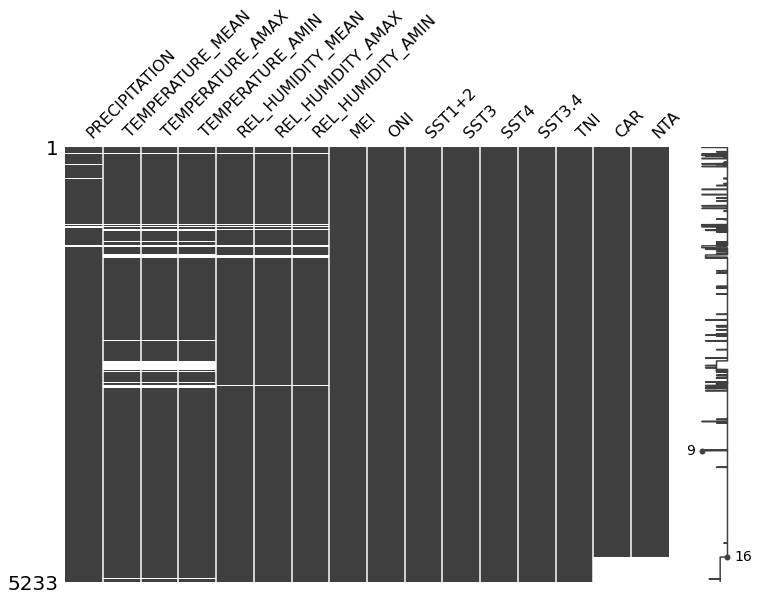

In [39]:
%matplotlib inline
msno.matrix(df_daily.iloc[:,2:], figsize =(12,8))


-----------------

In [40]:
#df_daily_interp["TEMPERATURE_RANGE"] = df_daily_interp["TEMPERATURE_AMAX"]  - df_daily_interp["TEMPERATURE_AMIN"] 
threshold_dry = 0.1 # Characteristics of consecutive dry days variations in China (2016)
df_daily["DRY_DAYS"] = df_daily["PRECIPITATION"].apply(lambda x: 1 if x < threshold_dry else 0)
df_daily = df_daily.reset_index()
df_daily.head(2)

FECHA   ANO SEMANA  PRECIPITATION  TEMPERATURE_MEAN  TEMPERATURE_AMAX  \
0 2006-09-03  2006     36            NaN               NaN               NaN   
1 2006-09-04  2006     36            0.0         27.879167              34.4   

   TEMPERATURE_AMIN  REL_HUMIDITY_MEAN  REL_HUMIDITY_AMAX  REL_HUMIDITY_AMIN  \
0               NaN                NaN                NaN                NaN   
1              24.1              72.75               86.0               50.0   

    MEI   ONI  SST1+2   SST3  SST4  SST3.4    TNI   CAR  NTA  DRY_DAYS  
0  0.63  0.54   21.43  25.74  29.4   27.34 -0.991  0.26  0.4         0  
1  0.63  0.54   21.43  25.74  29.4   27.34 -0.991  0.26  0.4         1

In [41]:
df_weekly_sums = df_daily[["ANO","SEMANA","PRECIPITATION","DRY_DAYS"]].groupby(["ANO","SEMANA"]).sum().reset_index()
df_weekly_maxes = df_daily[["ANO","SEMANA","TEMPERATURE_AMAX","REL_HUMIDITY_AMAX"]].groupby(["ANO","SEMANA"]).max().reset_index()
df_weekly_mins = df_daily[["ANO","SEMANA","TEMPERATURE_AMIN","REL_HUMIDITY_AMIN"]].groupby(["ANO","SEMANA"]).min().reset_index()
df_weekly_means = df_daily[['ANO', 'SEMANA', 'TEMPERATURE_MEAN','REL_HUMIDITY_MEAN', 'MEI','ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'CAR','NTA']].groupby(["ANO","SEMANA"]).mean().reset_index()
df_weekly_fecha = df_daily[['ANO','SEMANA','FECHA']].groupby(["ANO","SEMANA"]).min().reset_index()
df_weekly_fecha.FECHA = pd.to_datetime(df_weekly_fecha.FECHA)

In [42]:
df_weekly = pd.merge(df_weekly_sums,df_weekly_maxes, how = "left", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_mins, how = "left", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_means, how = "left", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_fecha, how = "left", on = ["ANO","SEMANA"] )
df_weekly.head(2)

ANO SEMANA  PRECIPITATION  DRY_DAYS  TEMPERATURE_AMAX  REL_HUMIDITY_AMAX  \
0  2006     36            0.0         6              38.2               89.0   
1  2006     37            0.0         7              39.6               94.0   

   TEMPERATURE_AMIN  REL_HUMIDITY_AMIN  TEMPERATURE_MEAN  REL_HUMIDITY_MEAN  \
0              23.4               32.0         29.159722          62.486111   
1              23.5               33.0         29.475362          61.809472   

    MEI   ONI  SST1+2   SST3  SST4  SST3.4    TNI   CAR  NTA      FECHA  
0  0.63  0.54   21.43  25.74  29.4   27.34 -0.991  0.26  0.4 2006-09-03  
1  0.63  0.54   21.43  25.74  29.4   27.34 -0.991  0.26  0.4 2006-09-10

# Dengue cases workflow

In [43]:
df_dengue = pd.read_csv(path_base+"prepared_dengue/dengue_weekly_2007_2020.csv", dtype={'COD_MUNICIPIO':str})
df_dengue = df_dengue[df_dengue["COD_MUNICIPIO"]==cod_municipio]
df_dengue.FECHA = pd.to_datetime(df_dengue.FECHA)
#df_dengue["FECHA"] = pd.to_datetime(df_dengue["FECHA"])
df_weekly["SEMANA"] = df_weekly["SEMANA"].astype('int')
df_weekly["ANO"] = df_weekly["ANO"].astype('int')
df_weekly = pd.merge(df_weekly,df_dengue, how = "left", on = ["FECHA","ANO","SEMANA"] )
df_weekly.index = df_weekly.FECHA

# Elevation and population workflow

In [44]:
df_population = pd.read_csv(path_base+"src_general/data_per_year.csv", dtype={"COD_MUNICIPIO":str})
df_population["COD_MUNICIPIO"] = df_population["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_population = df_population[df_population["COD_MUNICIPIO"]==cod_municipio]
df_population.head(2)

ANO COD_MUNICIPIO  COD_DPTO  DENGUE  DENGUE GRAVE  \
737   2006         54001        54       0             0   
1828  2007         54001        54    2400           546   

      MORTALIDAD POR DENGUE  POBLACION  
737                       0   593766.0  
1828                      6   599905.0

In [45]:
df_municipios = pd.read_csv(path_base+"src_general/departments.csv")
df_municipios["COD_MUNICIPIO"] = df_municipios["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_municipios = df_municipios[df_municipios["COD_MUNICIPIO"]==cod_municipio]
df_weekly = pd.merge(df_weekly, df_population[["ANO","POBLACION"]], how = "left", on = "ANO")

In [46]:
df_weekly = df_weekly.set_index(["FECHA","COD_DPTO","COD_MUNICIPIO","POBLACION"])
df_weekly = df_weekly.reset_index()
df_weekly = df_weekly.set_index("FECHA")
df_weekly["COD_DPTO"] = str(df_weekly["COD_DPTO"].unique()[-1]).zfill(2)
df_weekly["COD_MUNICIPIO"] = df_weekly["COD_MUNICIPIO"].unique()[-1]
df_weekly


COD_DPTO COD_MUNICIPIO  POBLACION   ANO  SEMANA  PRECIPITATION  \
FECHA                                                                       
2006-09-03     54.0         54001   593766.0  2006      36           0.00   
2006-09-10     54.0         54001   593766.0  2006      37           0.00   
2006-09-17     54.0         54001   593766.0  2006      38           0.00   
2006-09-24     54.0         54001   593766.0  2006      39           0.00   
2006-10-01     54.0         54001   593766.0  2006      40           0.00   
...             ...           ...        ...   ...     ...            ...   
2020-11-29     54.0         54001   680568.0  2020      49           5.07   
2020-12-06     54.0         54001   680568.0  2020      50           0.60   
2020-12-13     54.0         54001   680568.0  2020      51           0.00   
2020-12-20     54.0         54001   680568.0  2020      52           1.57   
2020-12-27     54.0         54001   680568.0  2020      53           0.00   

            DRY_DAYS  TEMPERATURE_AMAX  REL_HUMIDITY_AMAX  TEMPERATURE_AMIN  \
FECHA                                                                         
2006-09-03         6              38.2               89.0              23.4   
2006-09-10         7              39.6               94.0              23.5   
2006-09-17         7              38.8               94.0              23.0   
2006-09-24         7              39.1               90.0              24.0   
2006-10-01         7              38.5               95.0              22.9   
...              ...               ...                ...               ...   
2020-11-29         5              32.3               99.0              22.1   
2020-12-06         6              32.1               99.0              23.1   
2020-12-13         7              31.6               99.0              21.9   
2020-12-20         4              30.8               99.0              21.6   
2020-12-27         4              29.8               99.0              21.9   

            ...     SST1+2   SST3       SST4     SST3.4    TNI   CAR   NTA  \
FECHA       ...                                                              
2006-09-03  ...  21.430000  25.74  29.400000  27.340000 -0.991  0.26  0.40   
2006-09-10  ...  21.430000  25.74  29.400000  27.340000 -0.991  0.26  0.40   
2006-09-17  ...  21.430000  25.74  29.400000  27.340000 -0.991  0.26  0.40   
2006-09-24  ...  21.430000  25.74  29.400000  27.340000 -0.991  0.26  0.40   
2006-10-01  ...  22.220000  25.96  29.440000  27.470000 -1.131  0.25  0.49   
...         ...        ...    ...        ...        ...    ...   ...   ...   
2020-11-29  ...  21.811429  24.22  27.724286  25.475714  0.455   NaN   NaN   
2020-12-06  ...  22.160000  24.38  27.650000  25.530000  0.571   NaN   NaN   
2020-12-13  ...  22.160000  24.38  27.650000  25.530000  0.571   NaN   NaN   
2020-12-20  ...  22.160000  24.38  27.650000  25.530000  0.571   NaN   NaN   
2020-12-27  ...  22.160000  24.38  27.650000  25.530000  0.571   NaN   NaN   

            DENGUE  DENGUE GRAVE  MORTALIDAD POR DENGUE  
FECHA                                                    
2006-09-03     NaN           NaN                    NaN  
2006-09-10     NaN           NaN                    NaN  
2006-09-17     NaN           NaN                    NaN  
2006-09-24     NaN           NaN                    NaN  
2006-10-01     NaN           NaN                    NaN  
...            ...           ...                    ...  
2020-11-29    11.0           1.0                    0.0  
2020-12-06    12.0           1.0                    0.0  
2020-12-13     2.0           2.0                    0.0  
2020-12-20     9.0           0.0                    0.0  
2020-12-27     2.0           0.0                    0.0  

[748 rows x 25 columns]

In [464]:
df_weekly.head()

COD_DPTO COD_MUNICIPIO  POBLACION   ANO  SEMANA  PRECIPITATION  \
FECHA                                                                       
2006-09-04      8.0         08001  1154642.0  2006      36            0.0   
2006-09-10      8.0         08001  1154642.0  2006      37            0.0   
2006-09-17      8.0         08001  1154642.0  2006      38            0.0   
2006-09-24      8.0         08001  1154642.0  2006      39            0.0   
2006-10-01      8.0         08001  1154642.0  2006      40            0.0   

            DRY_DAYS  TEMPERATURE_AMAX  REL_HUMIDITY_AMAX  TEMPERATURE_AMIN  \
FECHA                                                                         
2006-09-04         0               NaN                NaN               NaN   
2006-09-10         0               NaN                NaN               NaN   
2006-09-17         0               NaN                NaN               NaN   
2006-09-24         0               NaN                NaN               NaN   
2006-10-01         0               NaN                NaN               NaN   

            ...  SST1+2   SST3   SST4  SST3.4    TNI   CAR   NTA  DENGUE  \
FECHA       ...                                                            
2006-09-04  ...   21.43  25.74  29.40   27.34 -0.991  0.26  0.40     NaN   
2006-09-10  ...   21.43  25.74  29.40   27.34 -0.991  0.26  0.40     NaN   
2006-09-17  ...   21.43  25.74  29.40   27.34 -0.991  0.26  0.40     NaN   
2006-09-24  ...   21.43  25.74  29.40   27.34 -0.991  0.26  0.40     NaN   
2006-10-01  ...   22.22  25.96  29.44   27.47 -1.131  0.25  0.49     NaN   

            DENGUE GRAVE  MORTALIDAD POR DENGUE  
FECHA                                            
2006-09-04           NaN                    NaN  
2006-09-10           NaN                    NaN  
2006-09-17           NaN                    NaN  
2006-09-24           NaN                    NaN  
2006-10-01           NaN                    NaN  

[5 rows x 25 columns]

In [465]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_weekly.index,
            y=df_weekly["TEMPERATURE_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="WEEKLY "+"TEMPERATURE"+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

# Missing data imputation

<AxesSubplot:>

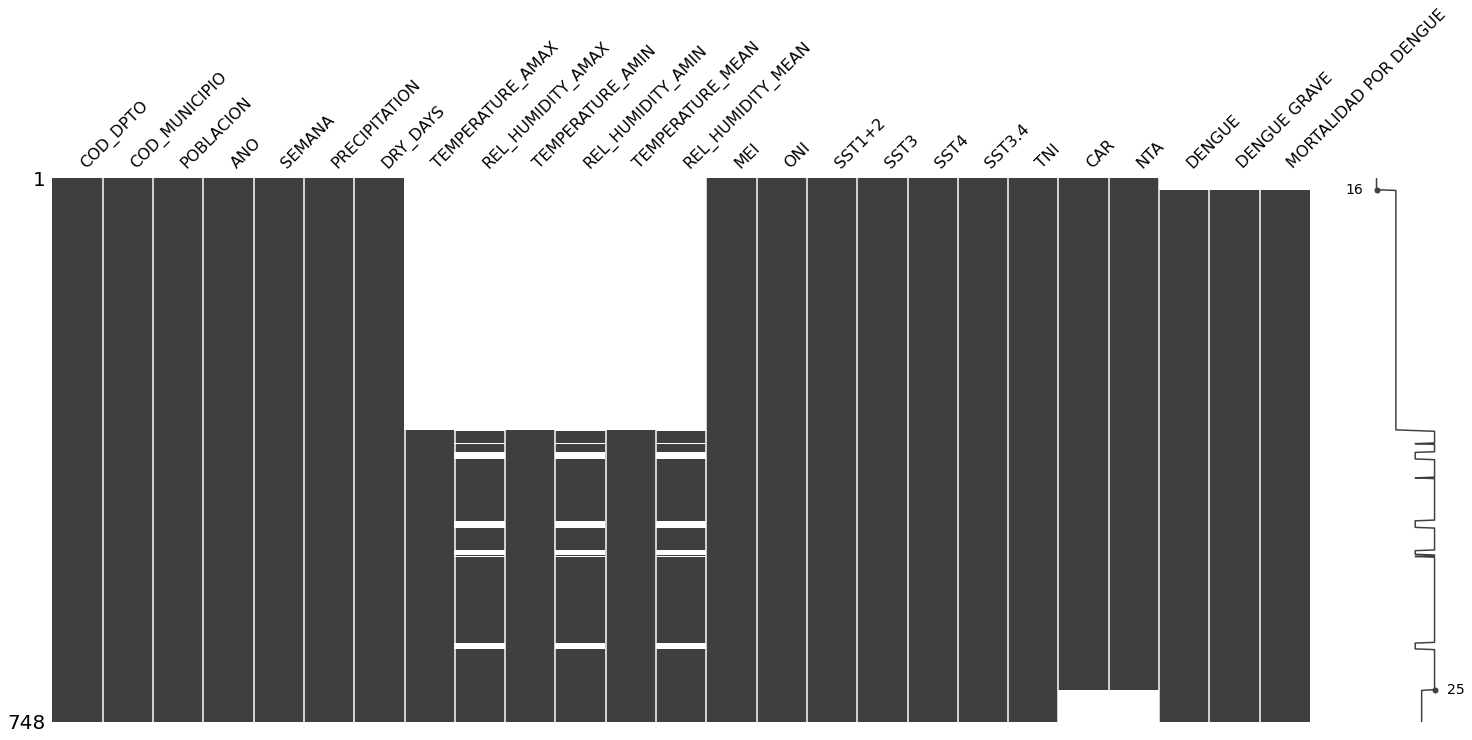

In [466]:
msno.matrix(df_weekly)

In [467]:
vars_to_imput = [
            "PRECIPITATION",
            "TEMPERATURE_MEAN",
            "TEMPERATURE_AMAX",
            "TEMPERATURE_AMIN",
            "REL_HUMIDITY_MEAN",
            "REL_HUMIDITY_AMAX",
            "REL_HUMIDITY_AMIN",
        ]

In [468]:
df_weekly_interp_model = df_weekly.copy()
df_weekly_interp_model.iloc[18:,:] = prep.imput_data_with_sklearn_imputer(df_weekly.iloc[18:,:])
df_weekly_interp = df_weekly.interpolate("nearest")
df_weekly_interp_means = prep.imput_with_mean_of_week(df_weekly)
df_weekly_imput_windowed = prep.imput_with_wind_mean_of_week(df_weekly)
df_weekly_final = df_weekly.copy()
df_weekly_final[vars_to_imput] = (df_weekly_interp_model[vars_to_imput]*0.1+df_weekly_imput_windowed[vars_to_imput]*0.9+df_weekly_interp[vars_to_imput]*0.)

In [469]:
df_weekly_final["TEMPERATURE_RANGE"] = df_weekly_final["TEMPERATURE_AMAX"] - df_weekly_final["TEMPERATURE_AMIN"]
df_weekly_final = df_weekly_final[['COD_DPTO', 'COD_MUNICIPIO', 'POBLACION', 'ANO', 'SEMANA',
    'PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX',
    'TEMPERATURE_AMIN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_AMIN', 'TEMPERATURE_MEAN',
    'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4',
    'TNI', 'CAR', 'NTA', 'DENGUE', 'DENGUE GRAVE', 'MORTALIDAD POR DENGUE']]

In [470]:
var = "TEMPERATURE_MEAN"
fig = go.Figure()
plot_temp = go.Scatter(x=df_weekly_final.index,
            y=df_weekly_final[var], name ="FILLED", mode = "lines")
plot_temp_nofill = go.Scatter(x=df_weekly.index,
            y=df_weekly[var], name ="ORIGINAL", mode = "lines")
fig.add_trace(plot_temp)
fig.add_trace(plot_temp_nofill)
layout = go.Layout(title="WEEKLY "+var+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [471]:
df_weekly_final.to_csv(path_base+f"prepared_per_city/{prep.municipality_name_to_filename(params['municipality'])}_consolidado_{params['starting_date'][0:4]}_2020.csv",index = True)

<AxesSubplot:>

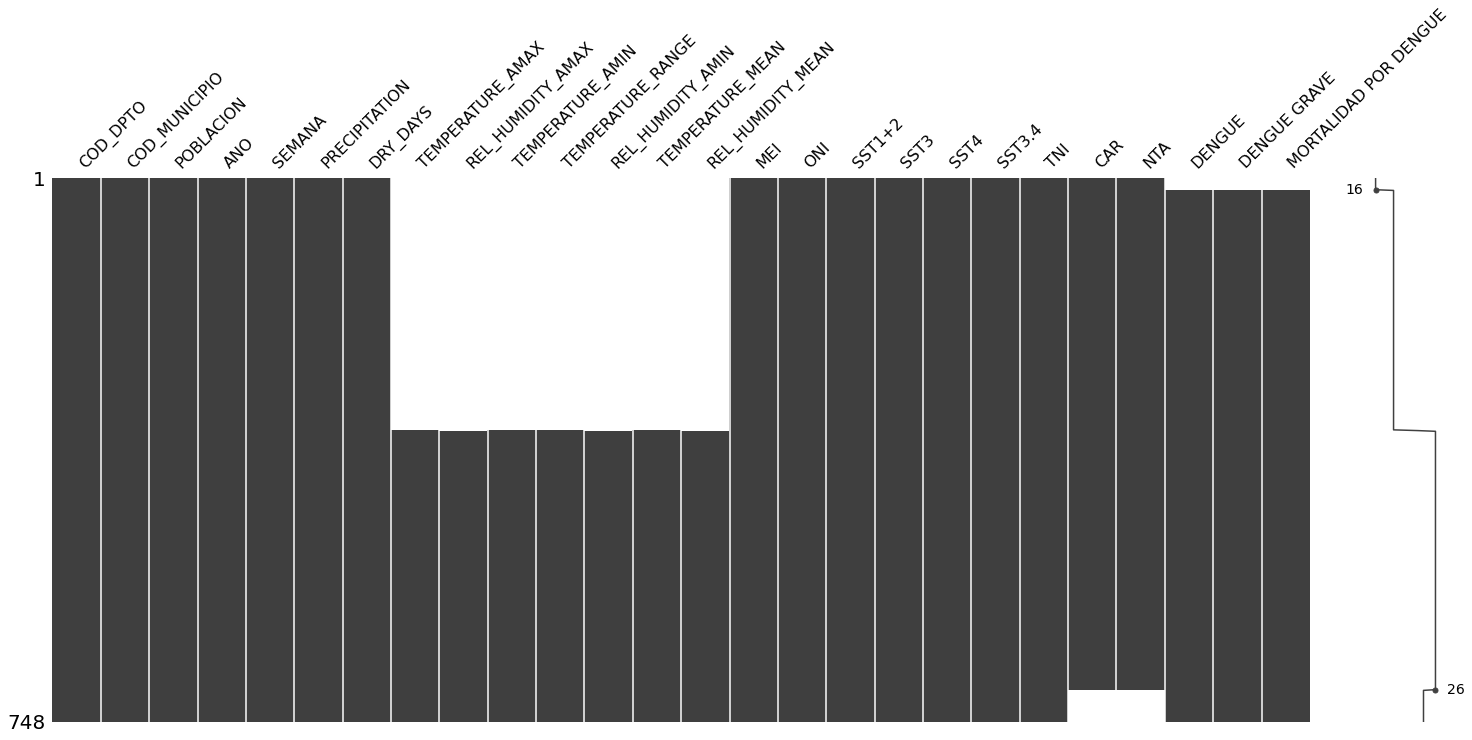

In [472]:
msno.matrix(df_weekly_final)

In [ ]:
#df_daily_interp = prep.imput_data_with_sklearn_imputer(df_daily)
#df_daily_interp = prep.imput_data_with_closest_and_mean(df_daily)
#df_daily_interp = df_daily.interpolate(method="time")
"""fig = go.Figure()
plot_temp = go.Scatter(x=df_daily.index,
            y=df_daily["TEMPERATURE_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="DAILY "+"TEMPERATURE"+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()
""";